### **- Project:**
#### This notebook contains data preprocessing, visualizations + DL model. 

### **- Dataset:**
#### The dataset used is sourced from dagshub. It has two folders, one for female's audio, and one for male. The dataset contains a total of 5993 samples, 3682 males, 2311 females. The format of the samples is `.WAV`. 

<div align="center">
  <img src="audio123.webp" alt="audio">
</div>



# 1.0 Data Preprocessing 

##### Necessary imports

In [41]:
import os
from collections import Counter
import joblib

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Audio Analysis
import librosa
import librosa.effects
import librosa.display

# Machine Learning & Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE



# CNN 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc

##### **Function for loading the datasets**
```python
def load_audio(folder): # Loads all .wav files in a folder and returns the audio data & sample rate.

In [42]:
def load_audio(folder): # Loads all .wav files in a folder and returns the audio data & sample rate.
    audio_files = []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            file_path = os.path.join(folder, file)
            y, sr = librosa.load(file_path, sr=16000) ## sr is the sample rate of an audio signal.
                                                    ## both male and female audio files already have a consistent sample rate of 16000 Hz.
            audio_files.append((y, sr))
            print(f" Loaded: {file}")
    return audio_files

In [43]:
male_path = "./males"
female_path = "./females"

male_audio = load_audio(male_path)

female_audio = load_audio(female_path)

total_files = len(male_audio) + len(female_audio)
print("Total of all audio files:", total_files)

 Loaded: 0.wav
 Loaded: 1.wav
 Loaded: 10.wav
 Loaded: 100.wav
 Loaded: 1000.wav
 Loaded: 1001.wav
 Loaded: 1002.wav
 Loaded: 1003.wav
 Loaded: 1004.wav
 Loaded: 1005.wav
 Loaded: 1006.wav
 Loaded: 1007.wav
 Loaded: 1008.wav
 Loaded: 1009.wav
 Loaded: 101.wav
 Loaded: 1010.wav
 Loaded: 1011.wav
 Loaded: 1012.wav
 Loaded: 1013.wav
 Loaded: 1014.wav
 Loaded: 1015.wav
 Loaded: 1016.wav
 Loaded: 1017.wav
 Loaded: 1018.wav
 Loaded: 1019.wav
 Loaded: 102.wav
 Loaded: 1020.wav
 Loaded: 1021.wav
 Loaded: 1022.wav
 Loaded: 1023.wav
 Loaded: 1024.wav
 Loaded: 1025.wav
 Loaded: 1026.wav
 Loaded: 1027.wav
 Loaded: 1028.wav
 Loaded: 1029.wav
 Loaded: 103.wav
 Loaded: 1030.wav
 Loaded: 1031.wav
 Loaded: 1032.wav
 Loaded: 1033.wav
 Loaded: 1034.wav
 Loaded: 1035.wav
 Loaded: 1036.wav
 Loaded: 1037.wav
 Loaded: 1038.wav
 Loaded: 1039.wav
 Loaded: 104.wav
 Loaded: 1040.wav
 Loaded: 1041.wav
 Loaded: 1042.wav
 Loaded: 1043.wav
 Loaded: 1044.wav
 Loaded: 1045.wav
 Loaded: 1046.wav
 Loaded: 1047.wav
 Load

##### This is just to check the sample rate. This is related to loading the datasets. We wanted to first verify that all `.wav` files have a consistent sample rate of 16000 Hz,so that we load them using `librosa.load(file_path, sr=16000)`. This ensures uniform processing of both male and female audio data.
 

```python
def check_sample_rates(folder): # Check sample rates of all audio files in a folder.

In [44]:
def check_sample_rates(folder):
                                #Check sample rates of all audio files in a folder
    sample_rates = []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            file_path = os.path.join(folder, file)
            _, sr = librosa.load(file_path, sr=None)  # Load with original SR
            sample_rates.append(sr)
    return sample_rates

**sample rates**

In [45]:
male_sample_rates = check_sample_rates(male_path)
female_sample_rates = check_sample_rates(female_path)

**rate counts based on the sample rates**

In [46]:
male_rate_count = Counter(male_sample_rates)
female_rate_count = Counter(female_sample_rates)

In [47]:
print("Male Sample Rate Counts:", male_rate_count)
print("Female Sample Rate Counts:", female_rate_count)

Male Sample Rate Counts: Counter({16000: 3682})
Female Sample Rate Counts: Counter({16000: 2311})


In [48]:
print(f"Total Male Files Loaded: {len(male_audio)}")
print(f"Total Female Files Loaded: {len(female_audio)}")


Total Male Files Loaded: 3682
Total Female Files Loaded: 2311


##### **Feature Extraction Process**

For each audio sample (male and female), we trim silence using a 20 dB threshold, normalize the signal, and extract the mean of 30 MFCC coefficients to obtain a fixed-size feature vector that captures the speech characteristics.

In [49]:
male_features = []
for y, sr in male_audio:
    y_trimmed, _ = librosa.effects.trim(y, top_db=20) # common threshold for trimming silence in speech audio 
                                                      # because it removes most quiet background noise while retaining the spoken content.
    y_normalized = y_trimmed / np.max(np.abs(y_trimmed))
    mfcc = np.mean(librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=30), axis=1)
    male_features.append(mfcc)

female_features = []
for y, sr in female_audio:
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    y_normalized = y_trimmed / np.max(np.abs(y_trimmed))
    mfcc = np.mean(librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=30), axis=1) 
    female_features.append(mfcc)


print(f"Male Features Extracted: {len(male_features)}")
print(f"Female Features Extracted: {len(female_features)}")


Male Features Extracted: 3682
Female Features Extracted: 2311


##### **Combining Features**

We create separate DataFrames for male (label=0) and female (label=1) features, and then concatenate them into a single DataFrame.


In [50]:
df_male = pd.DataFrame(male_features)
df_male["label"] = 0  # Male = 0

df_female = pd.DataFrame(female_features)
df_female["label"] = 1  # Female = 1

df = pd.concat([df_male, df_female], ignore_index=True)

df.to_csv("MeowCombined.csv", index=False)

In [51]:
print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5993 entries, 0 to 5992
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5993 non-null   float32
 1   1       5993 non-null   float32
 2   2       5993 non-null   float32
 3   3       5993 non-null   float32
 4   4       5993 non-null   float32
 5   5       5993 non-null   float32
 6   6       5993 non-null   float32
 7   7       5993 non-null   float32
 8   8       5993 non-null   float32
 9   9       5993 non-null   float32
 10  10      5993 non-null   float32
 11  11      5993 non-null   float32
 12  12      5993 non-null   float32
 13  13      5993 non-null   float32
 14  14      5993 non-null   float32
 15  15      5993 non-null   float32
 16  16      5993 non-null   float32
 17  17      5993 non-null   float32
 18  18      5993 non-null   float32
 19  19      5993 non-null   float32
 20  20      5993 non-null   float32
 21  21      5993 non-null   float32
 22  

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-164.864578,115.418404,9.210237,6.603998,13.448955,-15.594939,-3.285488,-5.482081,-2.223564,3.936115,...,-7.693189,-4.170288,-2.068751,-2.376416,0.073896,-2.955134,-0.826808,-2.670161,-0.616202,0
1,-85.443932,50.024097,25.308079,11.920931,-1.349575,-2.947205,-10.826738,-0.957338,-9.433150,0.536650,...,-3.751279,-2.938876,-5.746676,-4.149975,-3.031295,-5.583769,-4.527804,-6.203506,-4.035922,0
2,-159.627869,92.399101,10.027985,42.695240,-10.145677,-11.082030,-15.302072,-9.999508,-7.230575,-7.908084,...,-5.140301,-6.965596,-2.464635,-6.907821,-4.932817,-3.623661,-5.146464,-3.031968,-2.715763,0
3,-122.629402,98.151268,12.426086,29.811855,-14.078840,-11.545253,-17.418062,-6.793881,-17.033579,-3.518804,...,-6.783257,-8.600277,-7.024662,-10.071131,-5.252349,-7.785539,-5.962005,-8.418831,-5.876785,0
4,-65.265373,123.554604,-38.554962,6.158578,-14.966156,-8.327739,-19.021118,0.724525,-1.360817,-0.826843,...,1.210495,0.800584,1.121440,-2.149449,1.357037,-1.101589,1.562901,-2.928039,4.166633,0


#### **Checking for Null Values.**

In [52]:
print(df.isnull().sum())

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
label    0
dtype: int64


#### **Seperating features `X` and Labels `Y`**

In [53]:
X = df.drop(
    columns=["label"]
)                               # features (MFCC values)
y = df["label"]                 # labels (0 = male, 1 = female)

#### **Normalizing features `X`**
```python
scaler = StandardScaler()

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Place them back into the `df`

In [55]:
df = pd.DataFrame(X_scaled, columns=X.columns)
df["label"] = y  

df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.322536,0.578649,0.758821,-0.881117,1.802217,-0.852604,1.091624,0.183695,0.698645,1.044427,...,-1.435902,-0.157782,-0.170751,0.203915,0.310100,-0.188045,-0.041356,-0.244206,-0.058694,0
1,1.208357,-1.858086,1.540275,-0.516691,0.646771,0.341977,0.275573,0.695807,-0.257381,0.538104,...,-0.376109,0.205283,-1.187530,-0.303223,-0.560391,-0.925049,-1.069659,-1.240755,-1.023904,0
2,-0.221594,-0.279101,0.798518,1.592600,-0.040015,-0.426359,-0.208710,-0.327590,0.034691,-0.719672,...,-0.749551,-0.981942,-0.280195,-1.091811,-1.093453,-0.375483,-1.241550,-0.346251,-0.651292,0
3,0.491579,-0.064762,0.914932,0.709564,-0.347111,-0.470110,-0.437685,0.035225,-1.265234,-0.065924,...,-1.191264,-1.463906,-1.540835,-1.996339,-1.183028,-1.542370,-1.468144,-1.865568,-1.543485,0
4,1.597313,0.881821,-1.559892,-0.911647,-0.416391,-0.166216,-0.611154,0.886161,0.813049,0.335022,...,0.957877,1.307813,0.711192,0.268814,0.669808,0.331643,0.622612,-0.316938,1.291253,0


In [56]:
joblib.dump(scaler, 'scaler.pkl') #to use later in flask

['scaler.pkl']

#### **Dataset Balancing using SMOTE**

We apply SMOTE on the standardized features (`X_scaled`) and labels (`y`) to generate a balanced dataset by synthesizing samples for the minority class. The balanced features and labels are then combined into a DataFrame.


In [57]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

df = pd.DataFrame(X_balanced, columns=X.columns)
df["label"] = y_balanced

df["label"].value_counts()  # Check if classes are now equal


label
0    3682
1    3682
Name: count, dtype: int64

In [58]:
df.to_csv("MeowFinalTesting.csv", index=False)

In [59]:
print(df.info())
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7364 entries, 0 to 7363
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7364 non-null   float32
 1   1       7364 non-null   float32
 2   2       7364 non-null   float32
 3   3       7364 non-null   float32
 4   4       7364 non-null   float32
 5   5       7364 non-null   float32
 6   6       7364 non-null   float32
 7   7       7364 non-null   float32
 8   8       7364 non-null   float32
 9   9       7364 non-null   float32
 10  10      7364 non-null   float32
 11  11      7364 non-null   float32
 12  12      7364 non-null   float32
 13  13      7364 non-null   float32
 14  14      7364 non-null   float32
 15  15      7364 non-null   float32
 16  16      7364 non-null   float32
 17  17      7364 non-null   float32
 18  18      7364 non-null   float32
 19  19      7364 non-null   float32
 20  20      7364 non-null   float32
 21  21      7364 non-null   float32
 22  

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
count,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,...,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000,7364.000000
mean,0.014468,-0.058263,-0.038744,-0.049396,-0.061532,-0.031498,0.004379,0.066612,0.049064,0.000498,...,0.076496,0.011837,0.070978,0.069895,0.067081,0.074301,0.080262,0.065951,0.082563,0.500000
std,0.980957,0.981696,0.972726,0.973241,0.982853,0.979185,0.975029,0.978983,0.982517,0.977062,...,0.991253,0.999382,1.013778,1.016046,1.015338,1.022380,1.023695,1.021278,1.009232,0.500034
min,-4.988081,-4.179913,-5.441254,-4.635050,-4.139807,-4.856217,-6.041242,-5.110705,-3.705152,-5.077406,...,-3.949185,-5.414714,-3.178449,-3.660623,-5.361885,-3.125434,-3.044399,-3.853132,-3.073491,0.000000
25%,-0.633620,-0.739407,-0.668066,-0.670912,-0.692683,-0.669174,-0.610487,-0.555449,-0.593292,-0.614786,...,-0.560208,-0.626132,-0.577873,-0.601957,-0.587920,-0.604219,-0.607240,-0.612660,-0.595863,0.000000
50%,-0.000375,-0.074047,0.000615,-0.066367,-0.008264,-0.002702,0.028693,0.109807,0.055315,0.004628,...,0.030860,-0.042691,-0.015226,-0.033717,-0.039045,-0.054862,-0.057259,-0.085704,-0.064528,0.500000
75%,0.659900,0.593917,0.637119,0.567244,0.617728,0.609920,0.664264,0.728170,0.699999,0.661134,...,0.659969,0.578253,0.585624,0.617539,0.604152,0.613327,0.634584,0.588439,0.631426,1.000000
max,3.636351,4.833858,3.619238,4.806872,3.517750,4.011994,4.484151,4.145130,4.268666,3.507855,...,6.545842,5.819114,5.232903,5.659917,5.979932,5.459639,5.331693,5.830313,6.963885,1.000000


<div align="center">
  <img src="audio123.webp" alt="audio">
</div>



# 2.0 Visualizations 

In [60]:
values = df['label'].unique()
count = df['label'].value_counts().to_list()


fig = px.bar(
    x=['Male (0)', 'Female (1)'],
    y=count,
    title='Gender Distribution: Male vs. Female',
    labels={"x": "Gender", "y": "Number of Samples"},
    color=['Male', 'Female'],
    color_discrete_sequence=["#ADD8E6", "#FFB6C1"],
    
)

fig.update_layout(
      title={
        'x': 0.5,  
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Gender',
    yaxis_title='Samples',
    plot_bgcolor='rgba(255, 248, 252, 1)',
    paper_bgcolor='rgba(255, 248, 252, 1)',
    font=dict(family="Comic Sans MS", size=14, color="#4B0082"),
    title_font=dict(size=20, color="#FF69B4"),
    showlegend=False
)

fig.show()



We use this bar chart to visualize the distribution of male and female audio samples, ensuring that we have (or can create) a balanced dataset for training. In audio classification, such as distinguishing male from female voices, having roughly equal numbers of samples per class helps the model learn more effectively and avoid bias toward the majority class.

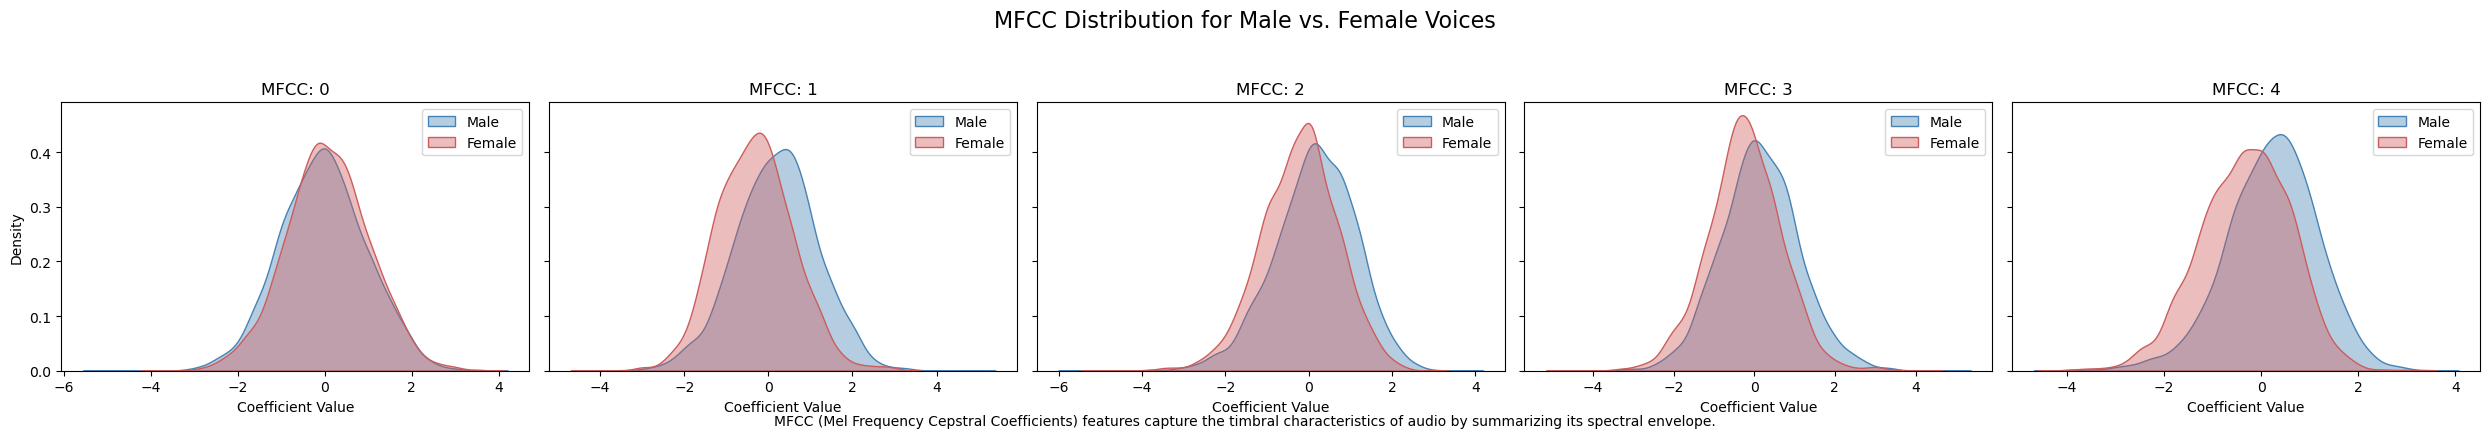

In [61]:
mfcc_columns = df.columns[:5]

colors = {'Male': 'steelblue', 'Female': 'indianred'}


fig, axes = plt.subplots(1, len(mfcc_columns), figsize=(5 * len(mfcc_columns), 4), sharey=True)

for ax, col in zip(axes, mfcc_columns):
    # Plot the KDE for male voices (label == 0)
    sns.kdeplot(
        data=df[df["label"] == 0],
        x=col,
        fill=True,
        color=colors['Male'],
        alpha=0.4,
        label='Male',
        ax=ax
    )
    # Plot the KDE for female voices (label == 1)
    sns.kdeplot(
        data=df[df["label"] == 1],
        x=col,
        fill=True,
        color=colors['Female'],
        alpha=0.4,
        label='Female',
        ax=ax
    )
    

    ax.set_title(f"MFCC: {col}")
    ax.set_xlabel("Coefficient Value")
    if ax == axes[0]:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    ax.legend()

plt.suptitle("MFCC Distribution for Male vs. Female Voices", fontsize=16, y=1.05)
plt.figtext(0.5, 0.01, 
            "MFCC (Mel Frequency Cepstral Coefficients) features capture the timbral characteristics of audio by summarizing its spectral envelope.",
            ha="center", fontsize=10)

plt.tight_layout()
plt.show()


We visualize the distributions of the first few MFCC coefficients to compare how male and female voices differ in terms of their spectral characteristics. This helps confirm that MFCCs capture distinct features for each class, which can improve the model’s ability to differentiate between male and female voices.

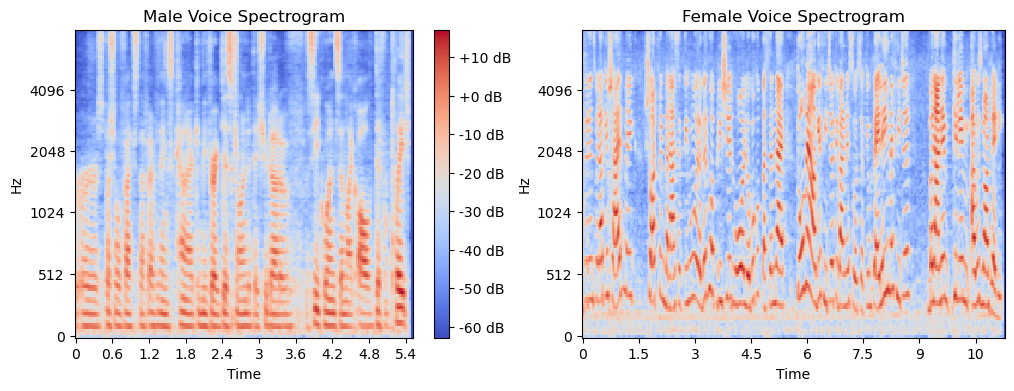

In [62]:
y_male, sr_male = male_audio[0]
y_female, sr_female = female_audio[0]
 
spec_male = librosa.feature.melspectrogram(y=y_male, sr=sr_male)
spec_female = librosa.feature.melspectrogram(y=y_female, sr=sr_female)
 
log_spec_male = librosa.power_to_db(spec_male)
log_spec_female = librosa.power_to_db(spec_female)
 
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
 
img1 = librosa.display.specshow(log_spec_male, sr=sr_male, x_axis="time", y_axis="mel", ax=ax[0])
ax[0].set_title("Male Voice Spectrogram")
 
img2 = librosa.display.specshow(log_spec_female, sr=sr_female, x_axis="time", y_axis="mel", ax=ax[1])
ax[1].set_title("Female Voice Spectrogram")
 
fig.colorbar(img1, ax=ax[0], format="%+2.0f dB")
plt.show()
 

We compare male and female spectrograms to visualize how their frequency content and intensities evolve over time, revealing key differences (e.g., pitch and formant patterns) that guide feature extraction and improve the accuracy of our voice classification.

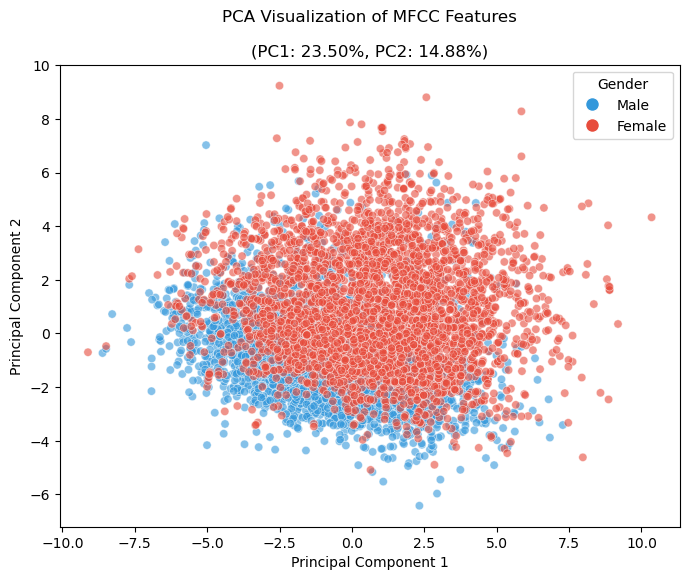

In [63]:
X = df.drop(columns=["label"])
y = df["label"]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_ * 100

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["label"] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], hue=df_pca["label"], 
                palette={0: "#3498DB", 1: "#E74C3C"}, alpha=0.6)

plt.title(f"PCA Visualization of MFCC Features\n\n(PC1: {explained_variance[0]:.2f}%, PC2: {explained_variance[1]:.2f}%)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498DB', markersize=10, label='Male'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E74C3C', markersize=10, label='Female')
]
plt.legend(handles=legend_handles, title="Gender", loc="best")

plt.show()




In this PCA plot, each point represents an audio sample reduced to two main components. Blue dots show male voices, and red dots show female voices. Although there is some separation, the overlap indicates that MFCC features capture some differences between genders but may not be enough on their own for a clear distinction.

<div align="center">
  <img src="audio123.webp" alt="audio">
</div>

## 3.0 Defining the baseline CNN Model

#### Reading the dataset and looking at general info by
```python
import pandas as pd
dataframe = pd.read_csv()
dataframe.info()

In [64]:
df = pd.read_csv("MeowFinalTesting.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7364 entries, 0 to 7363
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7364 non-null   float64
 1   1       7364 non-null   float64
 2   2       7364 non-null   float64
 3   3       7364 non-null   float64
 4   4       7364 non-null   float64
 5   5       7364 non-null   float64
 6   6       7364 non-null   float64
 7   7       7364 non-null   float64
 8   8       7364 non-null   float64
 9   9       7364 non-null   float64
 10  10      7364 non-null   float64
 11  11      7364 non-null   float64
 12  12      7364 non-null   float64
 13  13      7364 non-null   float64
 14  14      7364 non-null   float64
 15  15      7364 non-null   float64
 16  16      7364 non-null   float64
 17  17      7364 non-null   float64
 18  18      7364 non-null   float64
 19  19      7364 non-null   float64
 20  20      7364 non-null   float64
 21  21      7364 non-null   float64
 22  

#### The 1D convolution layers expect input of with the shape of: **(batch_size, timesteps, features)**  
#### The previous data array `X` is currently 2D shape containing only: `(samples, timesteps)` **because it has only one feature per timestep.**  
#### To make it compatible with `Conv1D` which is appropriate for audio processing, we add a singleton “features” dimension:

```python
# X used to only have (samples, timesteps)

X_cnn = X.reshape((X.shape[0], X.shape[1], 1))

# Now X_cnn has shape (samples, timesteps, 1)


In [65]:
# reshaping our data array 'X' for CNN audio processing to 3D: (samples, timesteps, features)
X = df.drop("label", axis=1).values
y = df["label"].values

print(f"Our data before reshaping: {X.shape}")


X_cnn = X.reshape(( 
    X.shape[0], 
    X.shape[1], 
    1
)) # now we have the suitable 3D shape for Conv1D Layers


print(f"Our data AFTER we are done with reshaping: {X_cnn.shape}")


Our data before reshaping: (7364, 30)
Our data AFTER we are done with reshaping: (7364, 30, 1)


#### Split data into train and test sets

We used an 80/20 data split, and the `startify`function uses stratification to maintain class balance:
```python
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y, test_size=0.2, random_state=42, stratify=y
)


In [66]:
# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y, test_size=0.20, random_state=42, stratify=y
)

#### **Building and compiling the 1D CNN Model**

Here we stack **three total** convolutional blocks with Conv1D, BatchNorm, MaxPooling, Dropout  
then flatten and add a dense head for binary classification. 
Finally, we compile with Adam and binary cross‐entropy.


In [67]:
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    # add the three blocks of 1DConv layers defined
    
    # first block is for low-level feature extraction
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # second block is for medium-level feature extraction
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # third block is for high-level feature extraction
    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # last layer/block for flatten and classification head
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    # this is our output layer, resulting in a one unit binary classifcation probability
    Dense(1, activation='sigmoid') 
])


# compile the model using the Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### `early_stop` stops training if `val_loss` doesn’t improve for 5 epochs and restore the best weights, ensuring that the best model is saved and preventing overfitting.
  


In [68]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

#### Saving our model's history and training logs in the history object.

In [69]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=30, # our training will be across 30 epochs
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stop], 
    verbose=2
)

Epoch 1/30
148/148 - 74s - 499ms/step - accuracy: 0.7175 - loss: 0.6504 - val_accuracy: 0.7676 - val_loss: 0.5179
Epoch 2/30
148/148 - 2s - 11ms/step - accuracy: 0.8200 - loss: 0.4262 - val_accuracy: 0.8507 - val_loss: 0.3709
Epoch 3/30
148/148 - 2s - 13ms/step - accuracy: 0.8589 - loss: 0.3495 - val_accuracy: 0.8779 - val_loss: 0.3160
Epoch 4/30
148/148 - 2s - 16ms/step - accuracy: 0.8686 - loss: 0.3295 - val_accuracy: 0.8880 - val_loss: 0.2861
Epoch 5/30
148/148 - 1s - 10ms/step - accuracy: 0.8771 - loss: 0.3004 - val_accuracy: 0.8830 - val_loss: 0.2889
Epoch 6/30
148/148 - 1s - 10ms/step - accuracy: 0.8909 - loss: 0.2756 - val_accuracy: 0.8940 - val_loss: 0.2722
Epoch 7/30
148/148 - 2s - 12ms/step - accuracy: 0.8986 - loss: 0.2631 - val_accuracy: 0.9016 - val_loss: 0.2689
Epoch 8/30
148/148 - 2s - 12ms/step - accuracy: 0.9013 - loss: 0.2641 - val_accuracy: 0.8991 - val_loss: 0.2602
Epoch 9/30
148/148 - 2s - 12ms/step - accuracy: 0.9098 - loss: 0.2368 - val_accuracy: 0.9067 - val_los

#### Train the model and generate our predictions based on a 0.5 threshold

In [70]:
# this threshold of 0.5 will turn the predictions made by the model by converting it to integers "int32".
# if the prediction was strictly greater than 0.5 then it will convert to 1 (female), otherwise it gets classified as
# 0 (male)  
y_pred = (model.predict(X_test) > 0.5).astype("int32")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step


In [71]:
accuracy = accuracy_score(
    y_test, 
    y_pred
)

print(f"\nModel Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       737
           1       0.91      0.92      0.91       736

    accuracy                           0.91      1473
   macro avg       0.91      0.91      0.91      1473
weighted avg       0.91      0.91      0.91      1473



#### Plotting the training history across the epochs

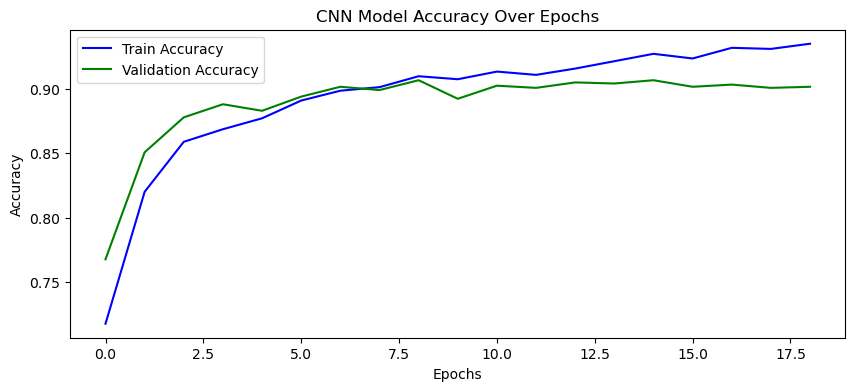

In [72]:
# Plot training history
plt.figure(
    figsize = (
        10, # adjust x and y scale of our figure size
        4
    )
)
plt.plot(
    history.history['accuracy'], # plot the training accuracy in a blue color
    label='Train Accuracy', 
    color='blue'
)

plt.plot(
    history.history['val_accuracy'], # plot the validation accuracy in a green color
    label='Validation Accuracy', 
    color='green'
)

# add the title and labels
plt.title('CNN Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Plotting the loss curve, in order to diagnose possibile overfitting

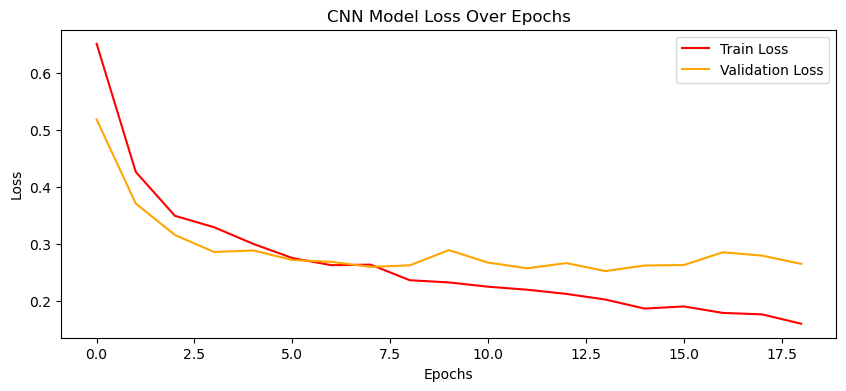

In [73]:
# Plot Loss Curve (to diagnose overfitting)
plt.figure(figsize=(10, 4))

plt.plot(
    history.history['loss'], # plot the loss in a red color
    label='Train Loss', color='red'
)

plt.plot(
    history.history['val_loss'], # plot the validation loss in an orange color
    label='Validation Loss', 
    color='orange'
)

# add title and labels
plt.title('CNN Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Plotting the confusion matrix

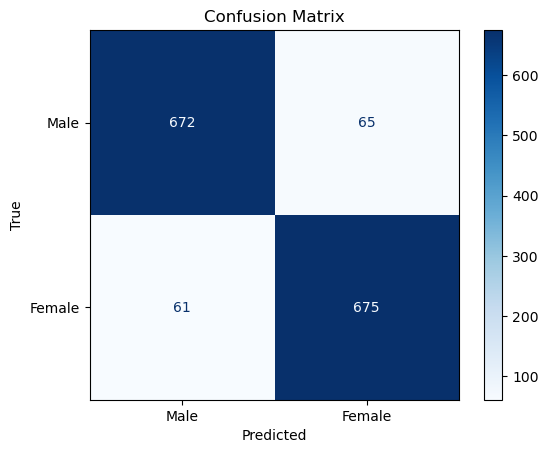

In [74]:
# calculate the confusion matrix
conf_matrix = confusion_matrix(
    y_test, 
    y_pred
)

# create the display object and plot the matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix = conf_matrix,
    display_labels   = ["Male", "Female"]
)

disp.plot(cmap="Blues")

# adding the title and the axis labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### ROC-AUC Plot to assess overall diagnostic performance of our CNN model

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


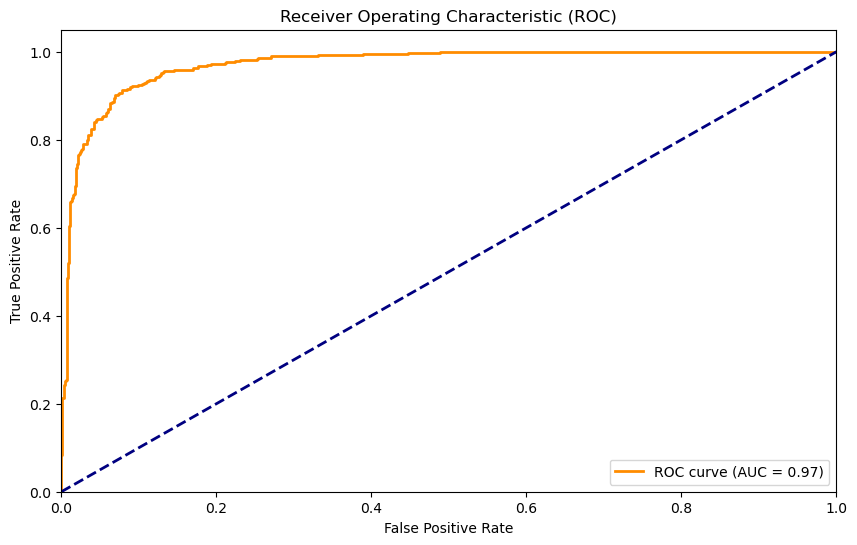

In [75]:
# obtain predicted probabilities for the positive class
y_pred_proba = model.predict(X_test).ravel()

# calculate ROC curve and the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr) # adjust it to the false positives rate and true positives rate from ROC

plt.figure(
    figsize=(
        10, # adjust the x and y scaled 
        6
    )
)

plt.plot(
    fpr, # false positive rates in x-axis
    tpr, # true positive rates in the y-axis
    color='darkorange', # highlight the curve in an dark orange
    lw=2, 
    label=f'ROC curve (AUC = {roc_auc:.2f})'
)

# adjust the plot styling
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# add labels and title, adjust the plot legend to the lower right position
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#### Displaying our final CNN model accuracy and percentage, recall that the model is nondeterministic

In [76]:
print(f"\n Final Model Accuracy and Percentage: {accuracy:.4f} ({accuracy * 100:.2f}%)")


 Final Model Accuracy and Percentage: 0.9145 (91.45%)


#### This custom defined function loads and preprocesses an audio file’s MFCC features just like we did in previous steps, then uses our CNN model to output the gender prediction for that audio file, used to run some test examples to validate the accuracy of our model


```python
def predict_gender_from_audio(file_path, model): 
    # loads an audio file and generates the gender prediction to it using the model

In [77]:
def predict_gender_from_audio(file_path, model): 
    # loads an audio file and generates the gender prediction to it using the model

    # preprocess the audio in the same way we did before (trim the silence, normalize, etc.) using librosa
    y, sr = librosa.load(file_path, sr=16000)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    y_normalized = y_trimmed / np.max(np.abs(y_trimmed))

    mfcc = np.mean(librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=30), axis=1)
    mfcc = mfcc.reshape(1, -1)  
    
    mfcc_scaled = scaler.transform(mfcc)
    mfcc_reshaped = mfcc_scaled.reshape((1, 30, 1)) 

    # use our defined CNN model from the parameter to generate a prediction for that audio sample provided
    prediction = model.predict(mfcc_reshaped)[0][0]
    
    # the prediction label is classified based on the same threshold that was used to generate training predictions,
    # strictly above .5 is a female, otherwise it's a male
    label = "Female" if prediction > 0.5 else "Male"
    
    # further more, the assigned label will be printed and returned by the function,
    # alongside with a confidence score
    print(f"Predicted Gender: {label} ({prediction:.4f})")
    return label


#### We tested the function on two audio files samples `AudioTest.wav` (female) and `AudioTestMale.wav` (male), and the function classified them accuractely.


In [78]:
predict_gender_from_audio("AudioTest.wav", model)
predict_gender_from_audio("AudioTestMale.wav", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Gender: Female (0.9085)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted Gender: Male (0.0789)


'Male'

In [79]:
# saving our final model
model.save("model-finalTest.keras")